In [2]:
import numpy as np
import cvxpy as cp
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing as mp
from threading import Thread
from math import erf
from scipy import optimize



In [3]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

class OptimisticBandit:
    def __init__(self, products, prices, budget, T, seed=42):
        self.T = T
        self.prices = prices

        # Scale is particularly important: it determines how much a point's update affects the points around it.
        # The higher the scale the more point-wise the gp is, the lower the smoother

        self.gps = [RBFGaussianProcess(scale=30).fit() for _ in range(len(products))]
        self.a_t = np.zeros(len(products))
        self.a_t_indices = np.zeros(len(products), dtype=int)
        self.mu_ts = np.zeros((len(products), len(prices)))
        self.sigma_ts = np.zeros((len(products), len(prices)))
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(self.T)))
        self.N_pulls = np.zeros((len(products), len(prices)))
        self.t = 1
        self.products = products
        self.rho_t = budget/T
        self.rhos = [self.rho_t]
        self.lr = 0.1
        self.rem_budget = budget
        self.idxs_by_product = {pr: i*len(prices) + np.arange(len(prices)) for i, pr in enumerate(self.products)}
        self.n_arms = len(prices)*len(products)
        self.rng = np.random.default_rng(seed)

        self.r_ucbs = []
        self.c_lcbs = []


    def plot_rhos(self):
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(len(self.rhos)), self.rhos[:len(self.rhos)])
        initial_value = self.rhos[0]
        plt.axline((0, initial_value), (1, initial_value), linewidth=4, color='r')
        plt.title("Agent's learnt rhos")
        plt.show()

    def amplify_bound(self, sigma):
        # Sigmas are between 0. and 1. so sqrt increases especially the values of sigmas close to 0.
        #return sigma
        return np.power(sigma, 0.5)


    def play(self):

        ucbs = np.zeros(len(self.products)*len(self.prices))
        lcbs = np.zeros(len(self.products)*len(self.prices))
        for i, (p, idxs) in enumerate(self.idxs_by_product.items()):
            self.mu_ts[i], self.sigma_ts[i] = self.gps[i].predict(self.prices)

            lcbs[idxs] = self.mu_ts[i] - self.beta(self.t) * self.sigma_ts[i]

            c_ucb = self.mu_ts[i] + self.beta(self.t) * self.amplify_bound(self.sigma_ts[i])
            ucbs[idxs] = c_ucb*self.prices
        #ucbs = np.clip(ucbs, 0., 1.)
        #
        lcbs = np.clip(lcbs, 0.005, 1.)
        self.r_ucbs.append(ucbs)
        self.c_lcbs.append(lcbs)

        """
        if self.t<0:
            for i, (p, idxs) in enumerate(self.idxs_by_product.items()):
                print(self.sigma_ts[i])
                plt.plot(self.prices, self.mu_ts[i]*self.prices)
                plt.fill_between(self.prices, self.mu_ts[i]*self.prices, ucbs[idxs], alpha=0.2)
                plt.title(f'Product {p}, iteration {self.t}')
                plt.show()
        """

        x = cp.Variable(self.n_arms)
        obj = cp.Maximize(ucbs @ x)
        constraints = [
            lcbs @ x <= self.rho_t,
            x >= 0,
        ]

        # Each product: choose at most one price
        for p, idxs in self.idxs_by_product.items():
            constraints.append(cp.sum(x[idxs]) == 1)

        # Default case
        xv = np.zeros(self.n_arms)
        for _, idxs in self.idxs_by_product.items():
            xv[idxs[-1]] = 1.0
        try:
            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.CLARABEL)
        except Exception as e:
            print(e)

        if x.value is not None:
            xv = np.asarray(x.value).ravel()
            # For some reason it sometimes happens that some values are greater than 1.
            xv = np.clip(xv, 0., 1.)

        # Build action: sample from xv
        for i, (p, idxs) in enumerate(self.idxs_by_product.items()):
            sum_x = np.sum(xv[idxs])
            normalized_p = xv[idxs]/sum_x
            k = self.rng.choice(idxs, p=normalized_p)
            idx = int(k%len(self.prices))

            self.a_t[i] = float(self.prices[idx])
            self.a_t_indices[i] = idx

        return self.a_t.copy()

    def plot_ucbs(self, extensive=False):
        R = np.asarray(self.r_ucbs)   # (t, A)
        C = np.asarray(self.c_lcbs)   # (t, A)
        t = np.arange(1, R.shape[0] + 1)
        if extensive:
            for i, p in enumerate(self.products):
                for k, pr in enumerate(self.prices):
                    k = i*len(self.prices) + k
                    fig, ax = plt.subplots(figsize=(7, 3))
                    ax.plot(t, R[:, k], label="r_ucb")
                    ax.plot(t, C[:, k], label="c_lcb")
                    ax.set_title(f"{p} @ {pr:g}")
                    ax.set_xlabel("time")
                    ax.set_ylabel("value")
                    ax.legend()
                    ax.grid(alpha=0.3)
                    plt.show()

        last_C = C[-1]  # (A,)
        for prod in self.products:
            idxs = self.idxs_by_product[prod]
            x = self.prices  # prices for this product
            y = last_C[idxs]              # last c_lcb for those arms

            order = np.argsort(x)
            x, y = x[order], y[order]

            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)

            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")

            ax.set_title(f"Last c_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last c_lcb")
            ax.grid(alpha=0.3)
            plt.show()

        last_R = R[-1]  # (A,)
        for prod in self.products:
            idxs = self.idxs_by_product[prod]
            x = self.prices   # prices for this product
            y = last_R[idxs]              # last c_lcb for those arms

            order = np.argsort(x)
            x, y = x[order], y[order]

            fig, ax = plt.subplots(figsize=(7, 3))
            ax.plot(x, y, linewidth=1, alpha=0.7)
            ax.scatter(x, y)

            # annotate each point with its y value
            for xi, yi in zip(x, y):
                ax.annotate(f"{yi:.4f}", (xi, yi),
                            textcoords="offset points", xytext=(6, 6), ha="left")

            ax.set_title(f"Last r_lcb by price — {prod}")
            ax.set_xlabel("price")
            ax.set_ylabel("last r_lcb")
            ax.grid(alpha=0.3)
            plt.show()

    def update(self, sold, ):
        self.N_pulls[np.arange(len(products)), self.a_t_indices] += 1
        self.gps = [self.gps[i].fit(self.prices[self.a_t_indices[i]], sold[i]) for i in range(len(sold))]
        self.t += 1

        tot_sold = np.sum(sold)
        self.rem_budget -= tot_sold
        self.rho_t = self.rho_t + self.lr*(self.rhos[0]-tot_sold)
        self.rhos.append(self.rho_t)

### Environment

In [4]:
class MultiProductPricingEnvironment:
    def __init__(self, products,
                 means,
                 covs,
                 seed=42,
                 plot_distribution=True,
                 T=None):
        self.products = products
        self.d = len(products)
        self.means, self.covs = self.delta_method_latent_from_logitnormal(means, covs)
        self.rng = np.random.default_rng(seed)
        self.cached_valuations = False

        if plot_distribution:
            n_samples = 100_000
            bins=100
            samples = self.sample_valuations(n_samples)
            for i, product in enumerate(products):

                plt.figure(figsize=(7, 3))
                plt.hist(samples[:, i], bins=bins, density=True)
                plt.title(f"Distribution of valuations for product {product} (100000 rounds)")
                plt.xlabel("valuation")
                plt.ylabel("density")
                plt.xlim(0, 1)
                plt.tight_layout()
                plt.show()

        if T is not None:
            self.valuations_samples = self.sample_valuations(T)
            self.cached_valuations = True
            self.i=0

    def compute_Q(self, prices_grid, eps = 1e-12):
        """
        Computes the real probabilities of a product to get sold
        A sale happens if W>=p (W logit-normal distr.), but since sigmoid is monotone it is equivalent to Y>=logit(p) (Y underlying normal)
        """

        # Standard deviations
        dvs = np.sqrt(np.clip(np.diag(self.covs), 0.0, None))

        # Logits of prices
        pc = np.clip(prices_grid, eps, 1 - eps)
        logits = np.log(pc / (1 - pc))

        # Calculations with the underlying normal
        Phi = lambda x: 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))
        z = (logits[None, :] - self.means[:, None]) / np.where(dvs > 0, dvs, 1.0)[:, None]
        Q = 1.0 - Phi(z)

        # Boundaries
        Q[:, prices_grid <= 0.0] = 1.0
        Q[:, prices_grid >= 1.0] = 0.0

        # If there are determinist prices (zero variance), set the prices above the valuation to 0 and 1 below
        det = dvs == 0.0
        if np.any(det):
            v = 1.0 / (1.0 + np.exp(-self.means[det]))
            Q[det] = (v[:, None] >= prices_grid[None, :]).astype(float)
        return Q



    @staticmethod
    def delta_method_latent_from_logitnormal(m, C):
        """
        Approximate latent Gaussian parameters (mu, Sigma_Z) for a multivariate logit-normal
        with desired mean vector m in (0,1)^d and covariance C.

        Uses first-order delta method:
            J = diag( m_i * (1 - m_i) )
            Sigma_Z ≈ J^{-1} C J^{-1}
            mu ≈ logit(m)
        """
        m = np.asarray(m, dtype=float)
        C = np.asarray(C, dtype=float)

        mu = logit(m)
        gprime = m * (1.0 - m)  # derivative of expit at mu where expit(mu)=m
        if np.any(gprime <= 0):
            raise ValueError("Means too close to 0 or 1 make the delta method unstable.")
        Jinv = np.diag(1.0 / gprime)
        Sigma_Z = Jinv @ C @ Jinv
        # Symmetrize small numerical asymmetry
        Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T)
        return mu, Sigma_Z

    def sample_valuations(self, n=1):
        if self.cached_valuations:
            self.i+=1
            return self.valuations_samples[self.i-1]
        z = self.rng.multivariate_normal(self.means, self.covs, size=n)
        if n==1:
            return expit(z).ravel()
        return expit(z)

    def round(self, chosen_prices):
        vals = self.sample_valuations()
        sold = (vals >= chosen_prices).astype(int)
        reward = np.multiply(chosen_prices, sold)
        return sold, reward


In [5]:
def compute_clairvoyant(price_grid, q_matrix, rho):
    """
    price_grid : shape (K,)
    q_matrix   : shape (N, K)  -> buy probabilities q_i(p_j)
    rho        : expected-units pace for the round

    Returns:
      x_opt : shape (N, K) probabilities for each of N products over K prices
      obj   : optimal expected profit per round
      used_units : sum q_i(p_j) * x_opt[i,j]
    """
    N, K = q_matrix.shape
    P = np.asarray(price_grid, dtype=float)
    V = q_matrix * P[None, :]              # expected profit per (i,j)
    r = V.reshape(-1)                      # objective coefficients
    c = q_matrix.reshape(-1)               # units coefficients
    n_atoms = N * K

    x = cp.Variable(n_atoms)

    obj = cp.Maximize(r @ x)
    constraints = [
        c @ x <= float(rho),
        x >= 0,
    ]

    # Each product: sum over its K prices equals 1 (mirrors your agent’s loop)
    for i in range(N):
        idxs = slice(i * K, (i + 1) * K)
        constraints.append(cp.sum(x[idxs]) == 1)

    prob = cp.Problem(obj, constraints)

    prob.solve(solver=cp.CLARABEL)

    xv = np.asarray(x.value).ravel() if x.value is not None else np.zeros(n_atoms)
    xv = np.clip(xv, 0.0, 1.0)
    X = xv.reshape(N, K)

    obj_val = float(prob.value) if prob.value is not None else 0.0
    used_units = float(np.sum(q_matrix * X))

    return X, obj_val, used_units


### Parallelization helper functions

In [6]:

def _progress_listener(q, n_trials, leave=False):
    """
    Render one tqdm bar per trial in the main process.
    Workers send ('init', trial_idx, total), ('update', trial_idx, n), ('close', trial_idx, 0).
    """
    bars = {}
    closed = set()
    while len(closed) < n_trials:
        msg = q.get()
        if msg is None:  # termination signal
            break
        kind, trial_idx, val = msg
        if kind == 'init':
            # Create the bar for this trial if not exists
            if trial_idx not in bars:
                bars[trial_idx] = tqdm(total=int(val),
                                       desc=f"Trial {trial_idx+1}",
                                       position=trial_idx,
                                       leave=leave)
        elif kind == 'update':
            if trial_idx in bars:
                bars[trial_idx].update(int(val))
        elif kind == 'close':
            if trial_idx in bars and trial_idx not in closed:
                bars[trial_idx].close()
                closed.add(trial_idx)

    # Ensure all bars are closed
    for tid, bar in bars.items():
        if tid not in closed:
            bar.close()

def _start_progress(n_trials, leave=False):
    mgr = mp.Manager()
    q = mgr.Queue()
    th = Thread(target=_progress_listener, args=(q, n_trials, leave), daemon=True)
    th.start()
    return q, th, mgr

# ----------------------------------------
# One trial (runs in a worker process)

def run_all_trials_parallel(seeds, products, prices, budget, T, means, covs, n_jobs=-1, leave=False):
    progress_q, progress_thread, mgr = _start_progress(len(seeds), leave=leave)
    try:
        results = Parallel(n_jobs=n_jobs, prefer="processes")(
            delayed(run_single_trial)(
                trial_idx, products, prices, budget, T, means, covs, seed, False, progress_q
            )
            for trial_idx, seed in enumerate(seeds)
        )
    finally:
        # tell listener to exit if not already
        progress_q.put(None)
        progress_thread.join()
        mgr.shutdown()

    all_regrets = [results[i][0] for i in range(len(results))]
    actions = [results[i][1] for i in range(len(results))]
    return all_regrets, actions


def run_single_trial(trial_idx, products, prices_per_product, budget, T, means, covs, seed=42, extensive_plots=False, progress_q=None):

    if progress_q is not None:
        progress_q.put(('init', trial_idx, T))

    env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, seed=seed, T=T, plot_distribution=False)
    agent = OptimisticBandit(products, prices_per_product, budget, T, seed=seed)
    # Actual probabilities for a product to get sold
    Q = env.compute_Q(prices_per_product)
    _, expected_clairvoyant_utility, _ = compute_clairvoyant(prices_per_product, Q, budget/T)

    cumulative_regret = []
    cum_reg = 0.0
    actions = []
    rhos = []
    rem_bud = budget

    for t in range(1, T + 1):
        if agent.rem_budget <= 0:
            # close early if budget exhausted
            if progress_q is not None:
                progress_q.put(('close', trial_idx, 0))
            break

        action = agent.play()
        sold, reward = env.round(action)

        rem_bud -= np.sum(sold)
        rho = rem_bud/(T-t+1)
        rhos.append(rho)

        agent.update(sold=sold)

        cum_reg += expected_clairvoyant_utility - reward.sum()
        cumulative_regret.append(cum_reg)
        actions.append(action)

        if progress_q is not None:
            progress_q.put(('update', trial_idx, 1))

    else:
        # loop ended normally
        if progress_q is not None:
            progress_q.put(('close', trial_idx, 0))

    # Extensive plots plot r and c bounds for each product, price and time instant. Otherwise just last step
    agent.plot_ucbs(extensive=extensive_plots)
    # Agent's learnt rhos
    agent.plot_rhos()
    # Effective rhos, based on remaining budget and time steps
    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(rhos)), rhos[:len(rhos)])
    plt.axline((0, rhos[0]), (1, rhos[0]), linewidth=4, color='r')
    plt.title('Effective rhos')
    plt.show()

    return cumulative_regret, actions


# Experiments

Discretizing prices with 14 values


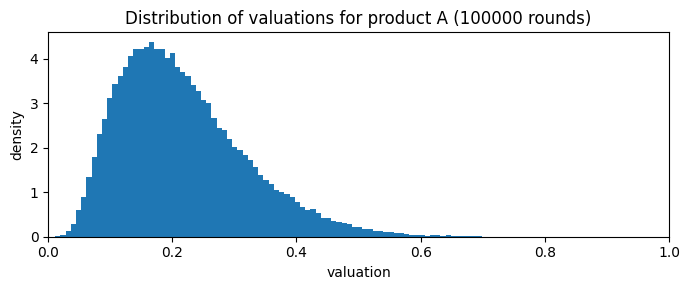

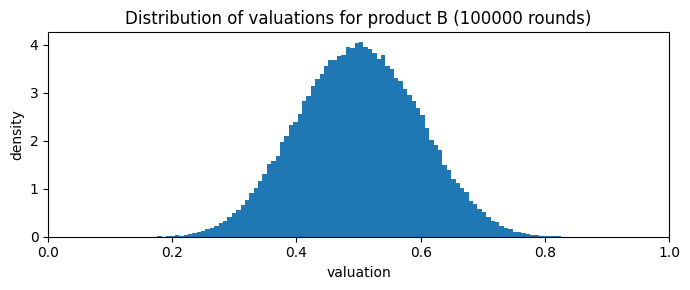

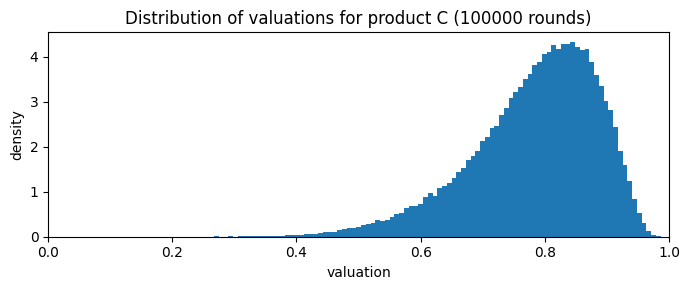

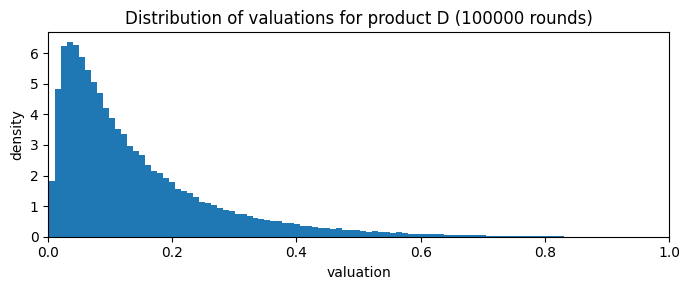

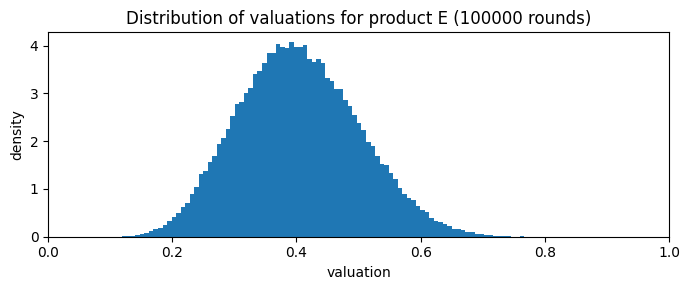

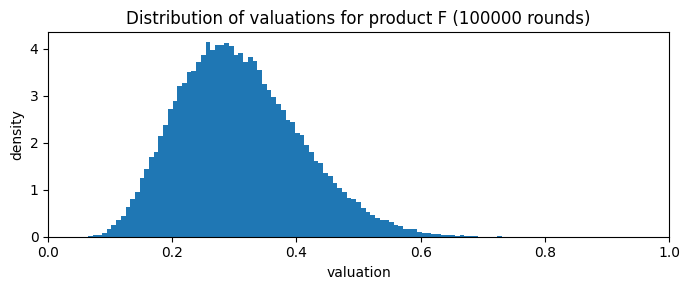

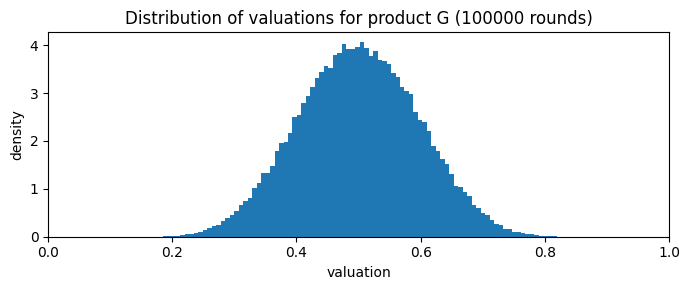

Trial 2:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 7:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/500 [00:00<?, ?it/s]

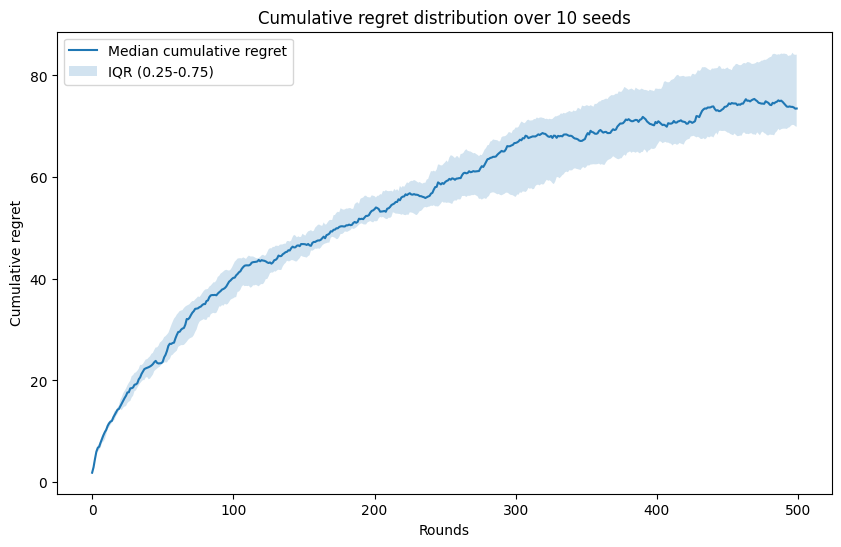

In [7]:

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 3000
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
#vars = 0.04*np.array([1., 2., 0.5, 0.1, 0.1, 5., 0.5])
vars = 0.01*np.ones(len(products))
#covs = 0.04*np.array([[1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.]])
covs = 0.*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)

# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)

    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

Discretizing prices with 14 values


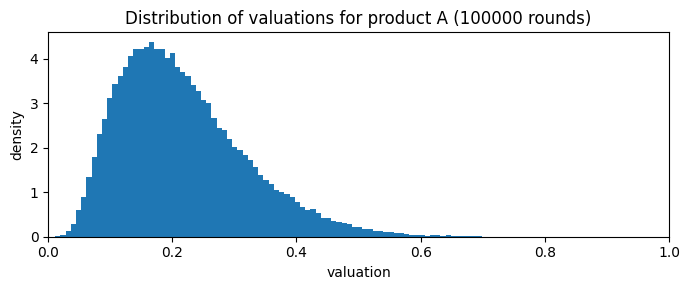

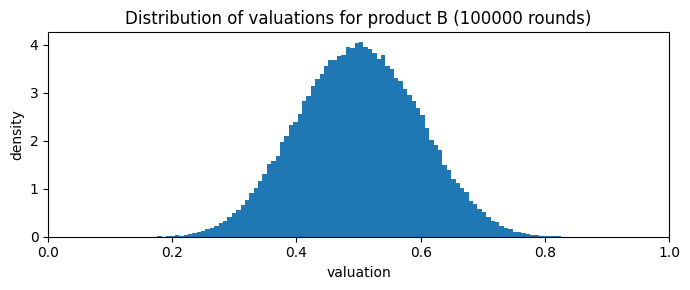

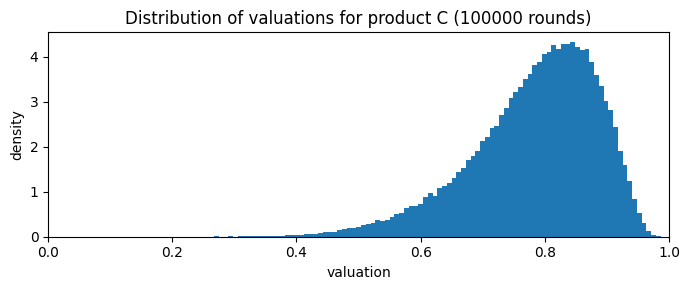

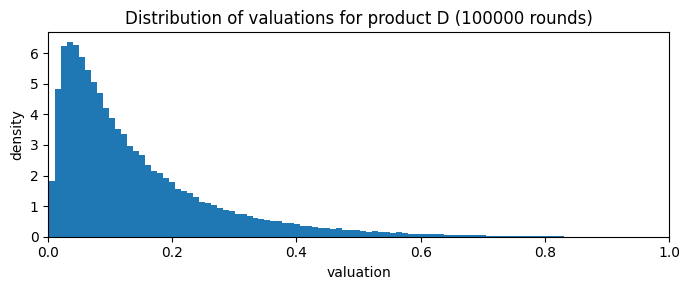

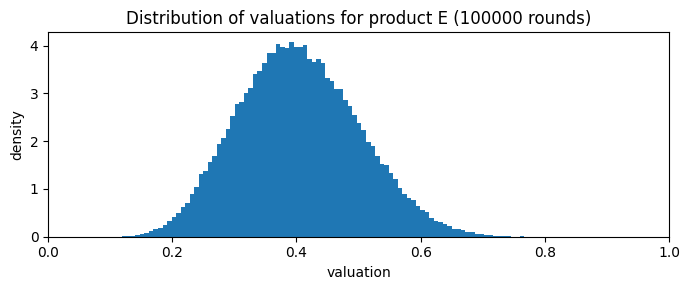

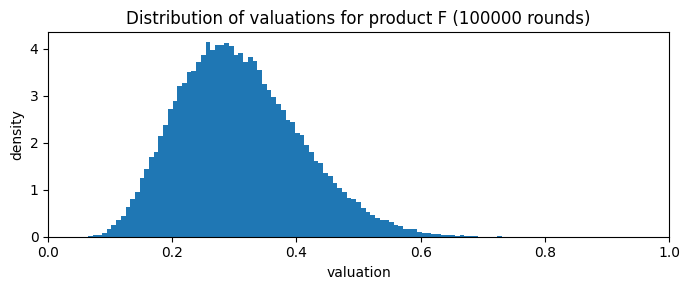

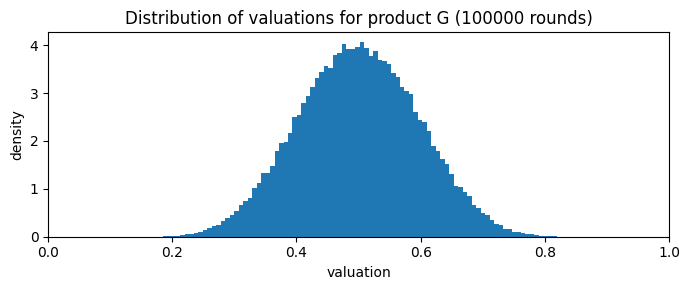

Trial 7:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 10:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 4:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 8:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 2:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 6:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 5:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 1:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 9:   0%|          | 0/500 [00:00<?, ?it/s]

Trial 3:   0%|          | 0/500 [00:00<?, ?it/s]

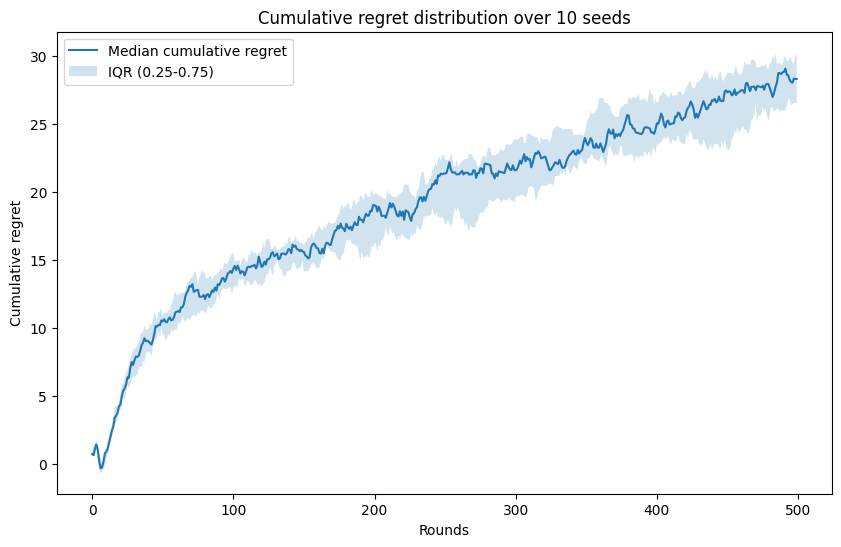

In [8]:

run_one = False
products = ['A','B','C', 'D', 'E', 'F', 'G']
budget = 500
T = 500
seeds = [23424,3431,65762,842357,2346532,13564,98765,2557,123564,12364]
epsilon = T ** (-0.33)
# The two was chosen empirically
K = 2*int(1 / epsilon)
print(f'Discretizing prices with {K} values')
prices_per_product = np.linspace(0, 1, K)
means = np.array([0.2, 0.5, 0.8, 0.1, 0.4, 0.3, 0.5])
#vars = 0.04*np.array([1., 2., 0.5, 0.1, 0.1, 5., 0.5])
vars = 0.01*np.ones(len(products))
#covs = 0.04*np.array([[1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.],
#                      [1., 0., 0., 0., 0., 0., 0.]])
covs = 0.*np.min(vars)*np.ones((len(products), len(products)))
np.fill_diagonal(covs, vars)

# Just to plot distribution
env = MultiProductPricingEnvironment(products=products, means=means, covs=covs, plot_distribution=True)

if run_one:
    cum_regret, actions = run_single_trial(0, products, prices_per_product, budget, T, means, covs, seed=3, extensive_plots=False)
    median_regret = cum_regret
else:
    all_regrets, actions = run_all_trials_parallel(seeds, products, prices_per_product, budget, T, means, covs, n_jobs=-1)

    all_regrets = np.array([np.pad(r, (0, T-len(r)), 'edge') for r in all_regrets])
    lq_regret, median_regret, hq_regret = np.quantile(all_regrets, q=[0.25, 0.5, 0.75], axis=0)

plt.figure(figsize=(10,6))
plt.plot(median_regret, label='Median cumulative regret')
if not run_one:
    plt.fill_between(range(T), lq_regret, hq_regret, alpha=0.2, label='IQR (0.25-0.75)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative regret')
plt.title(f'Cumulative regret distribution over {len(seeds)} seeds')
plt.legend()
plt.show()

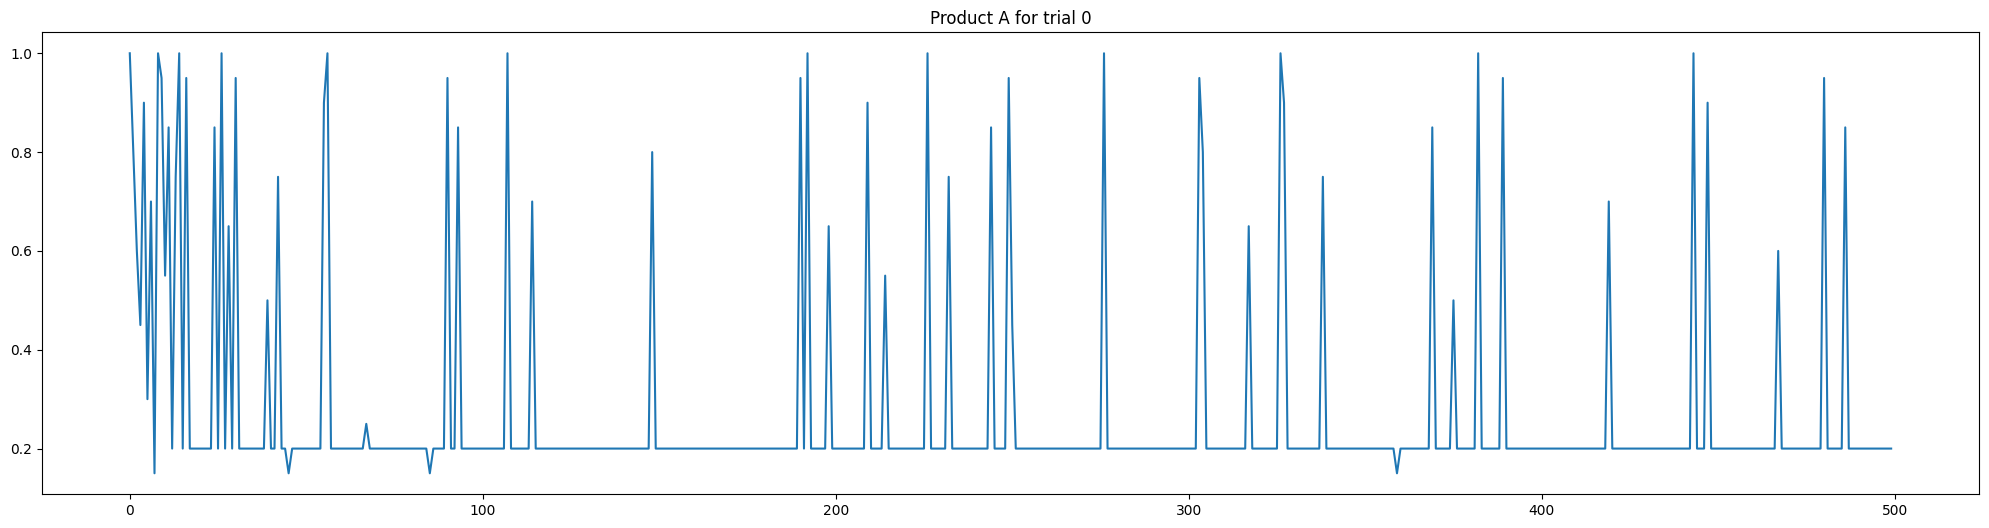

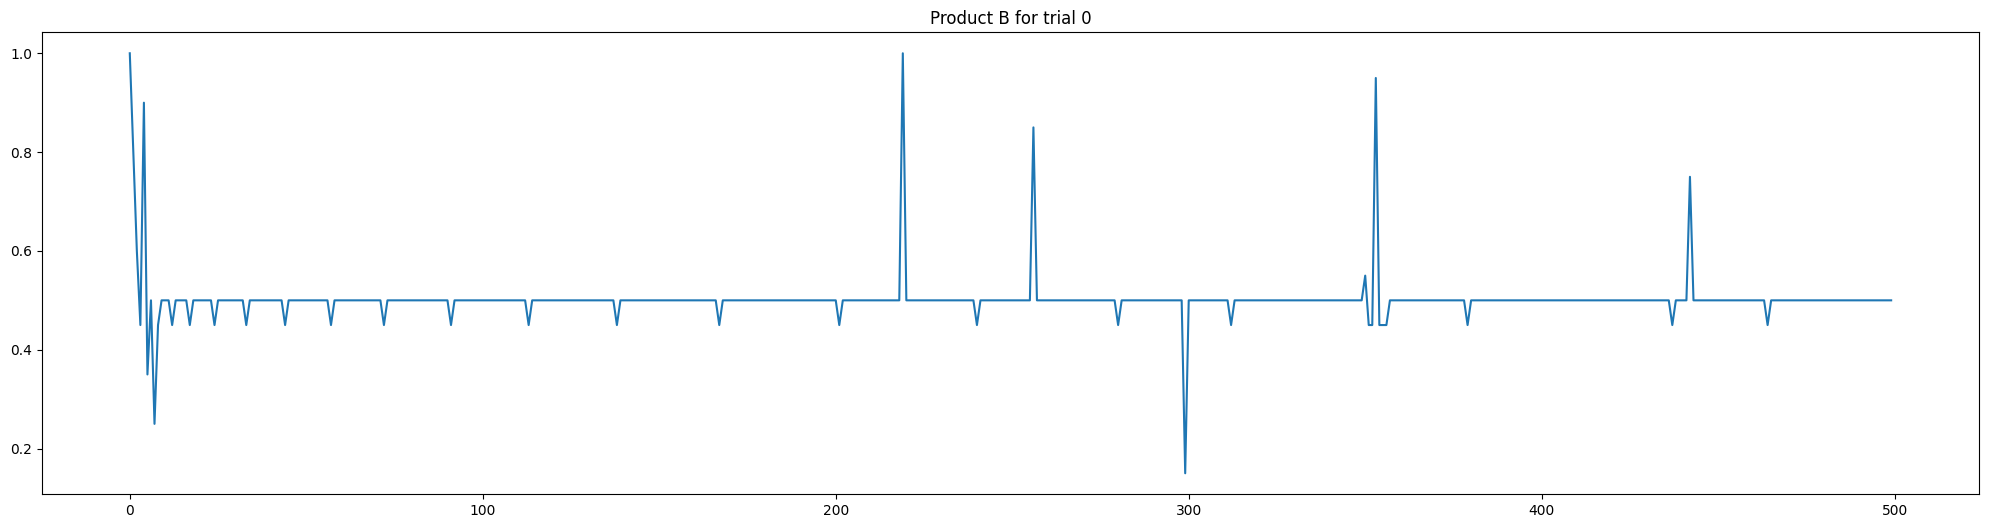

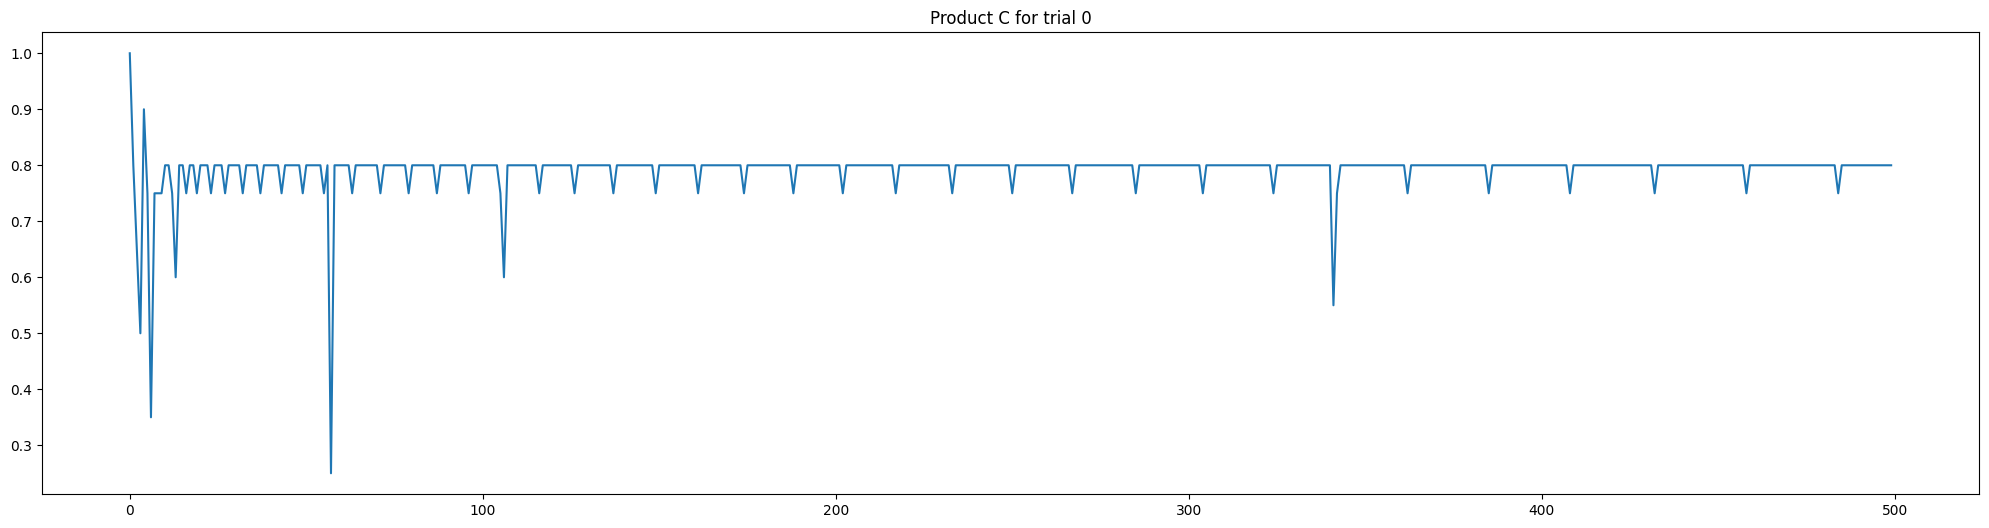

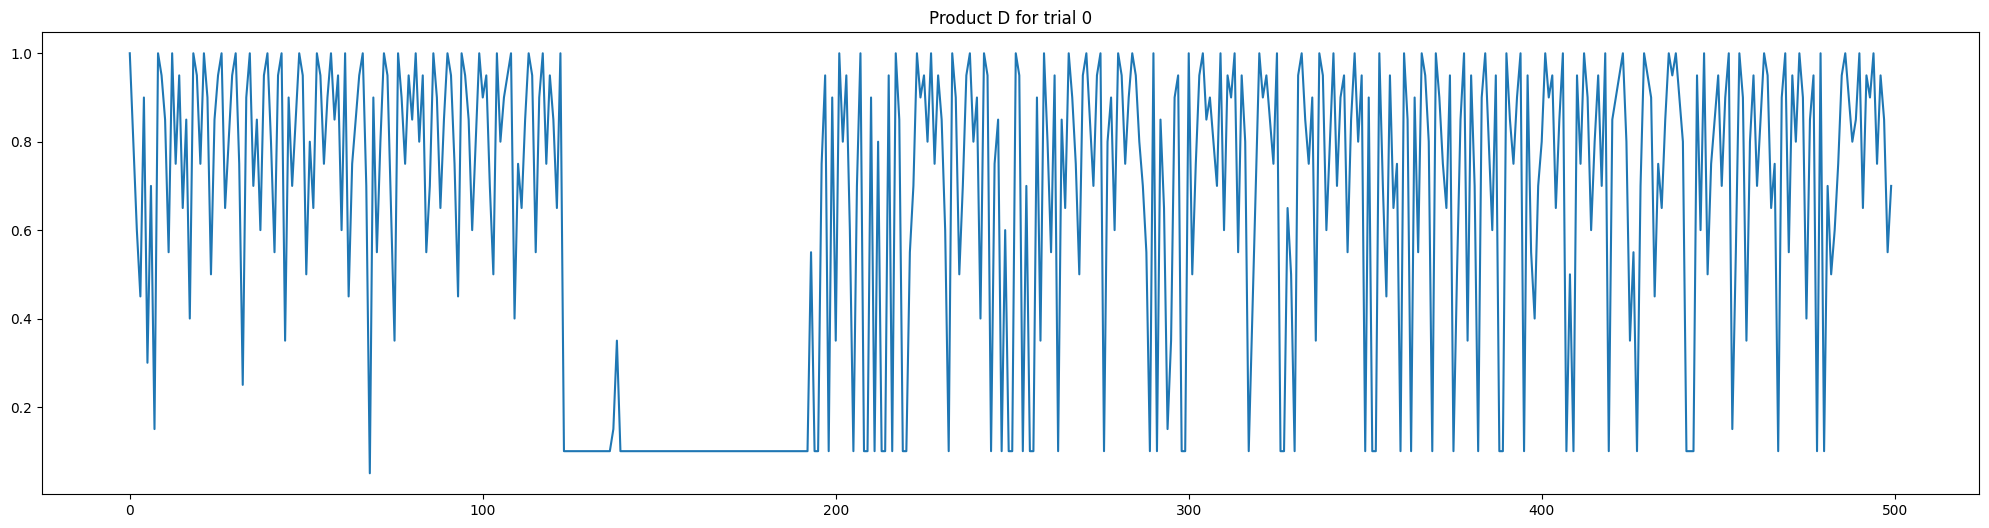

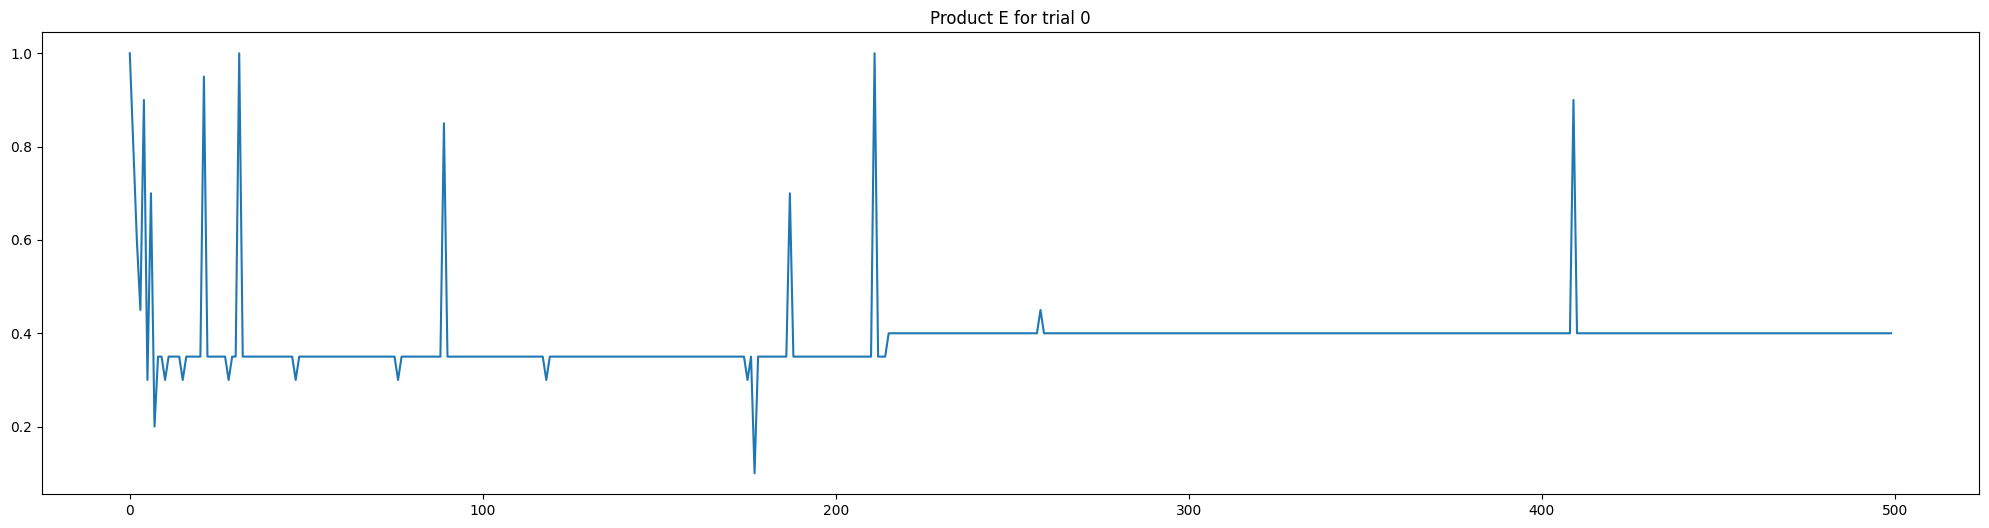

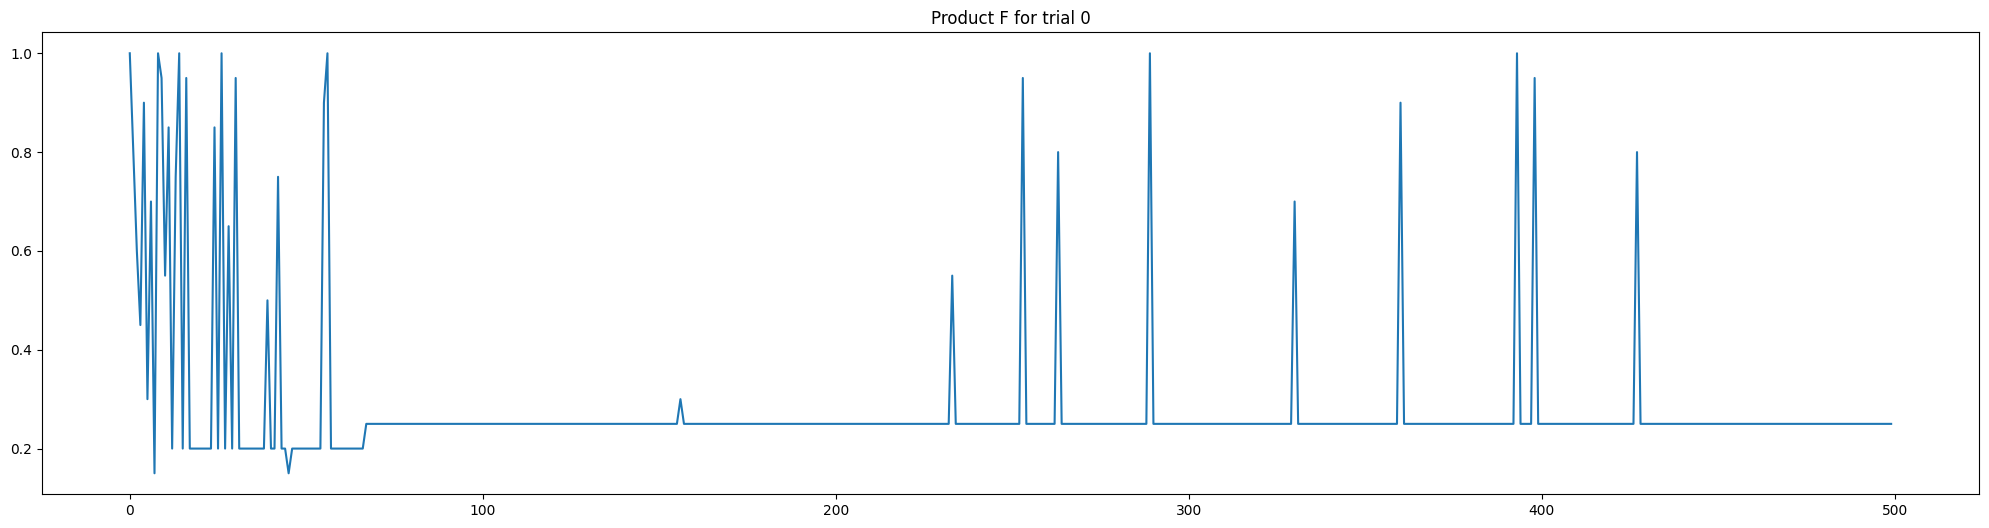

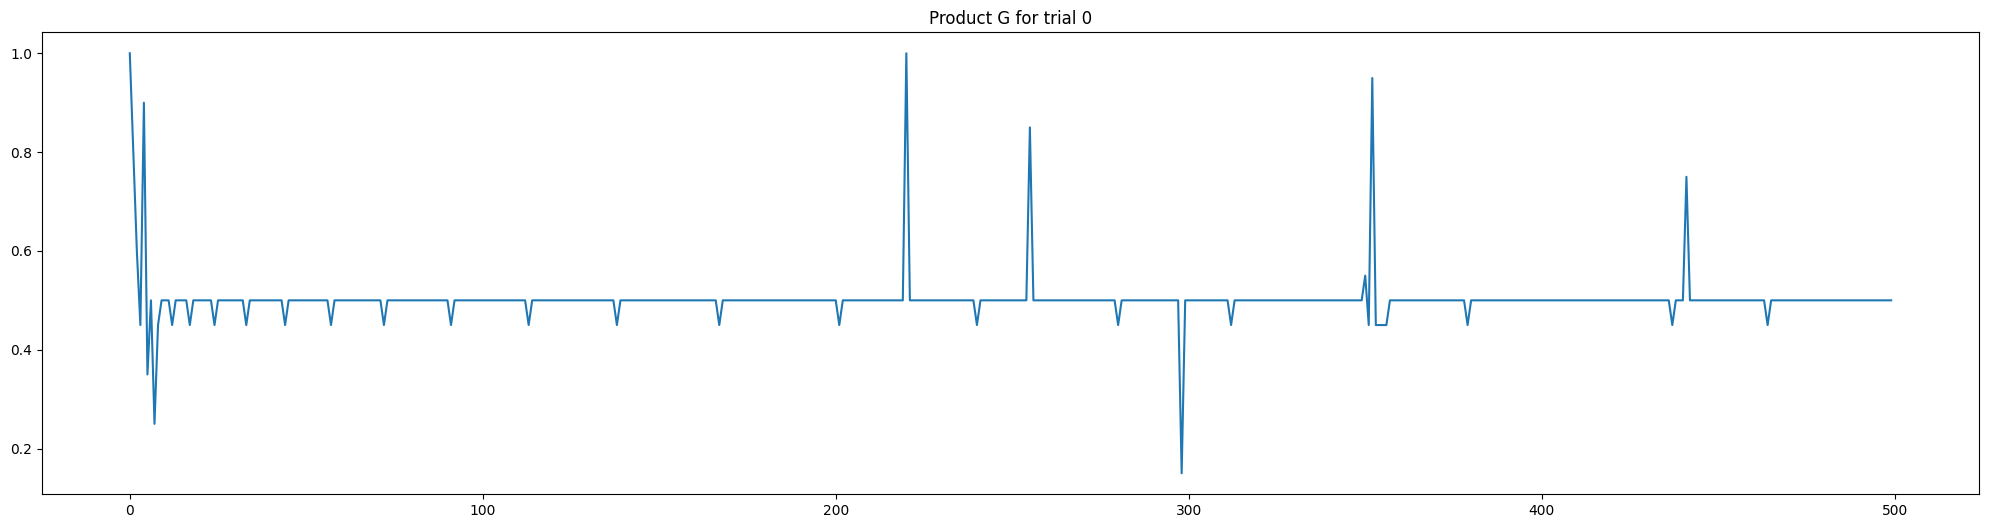

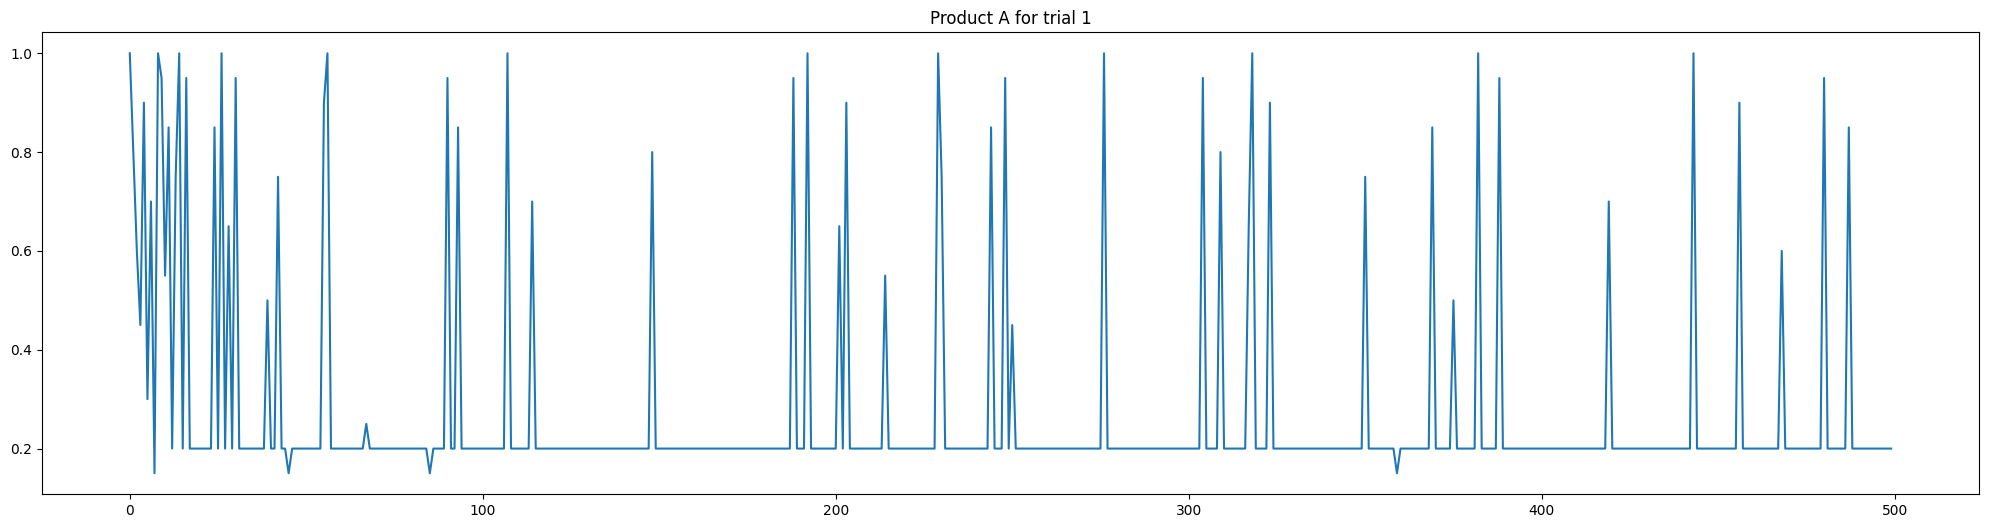

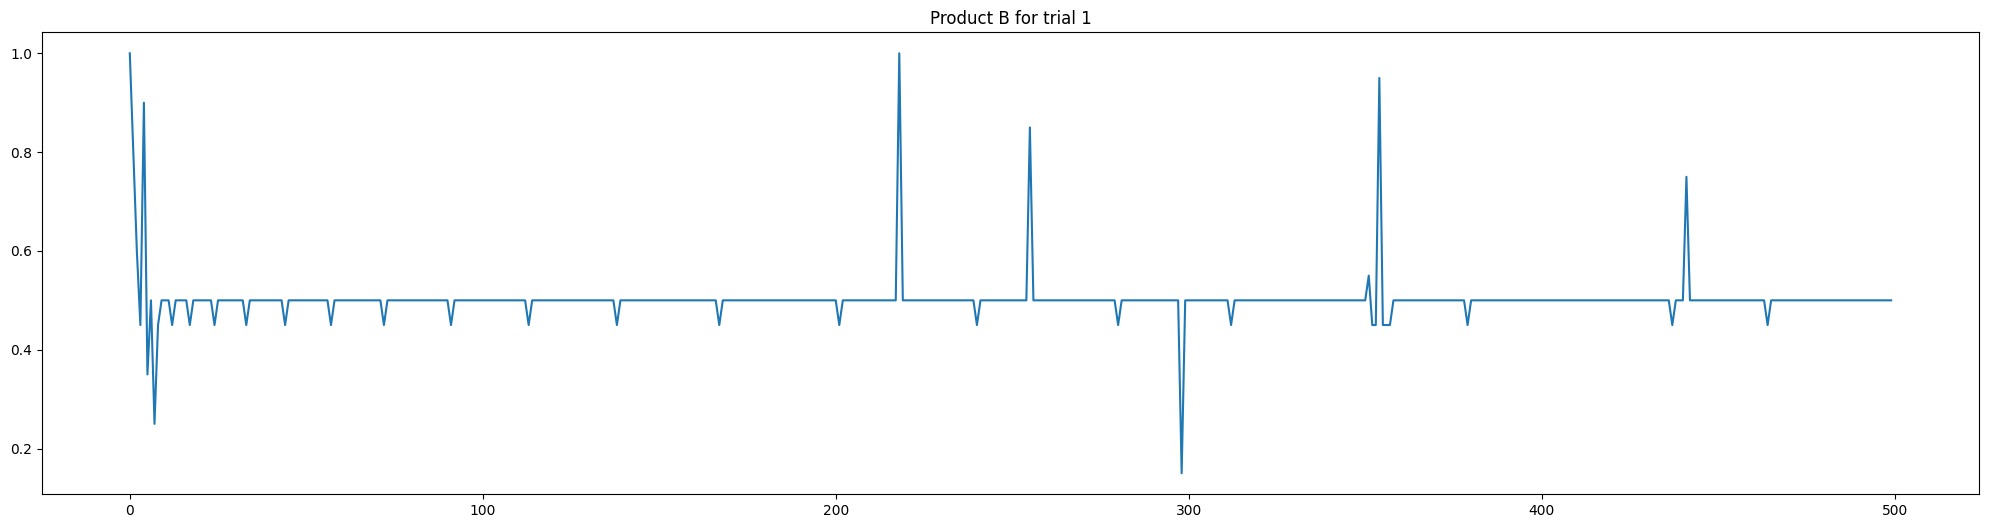

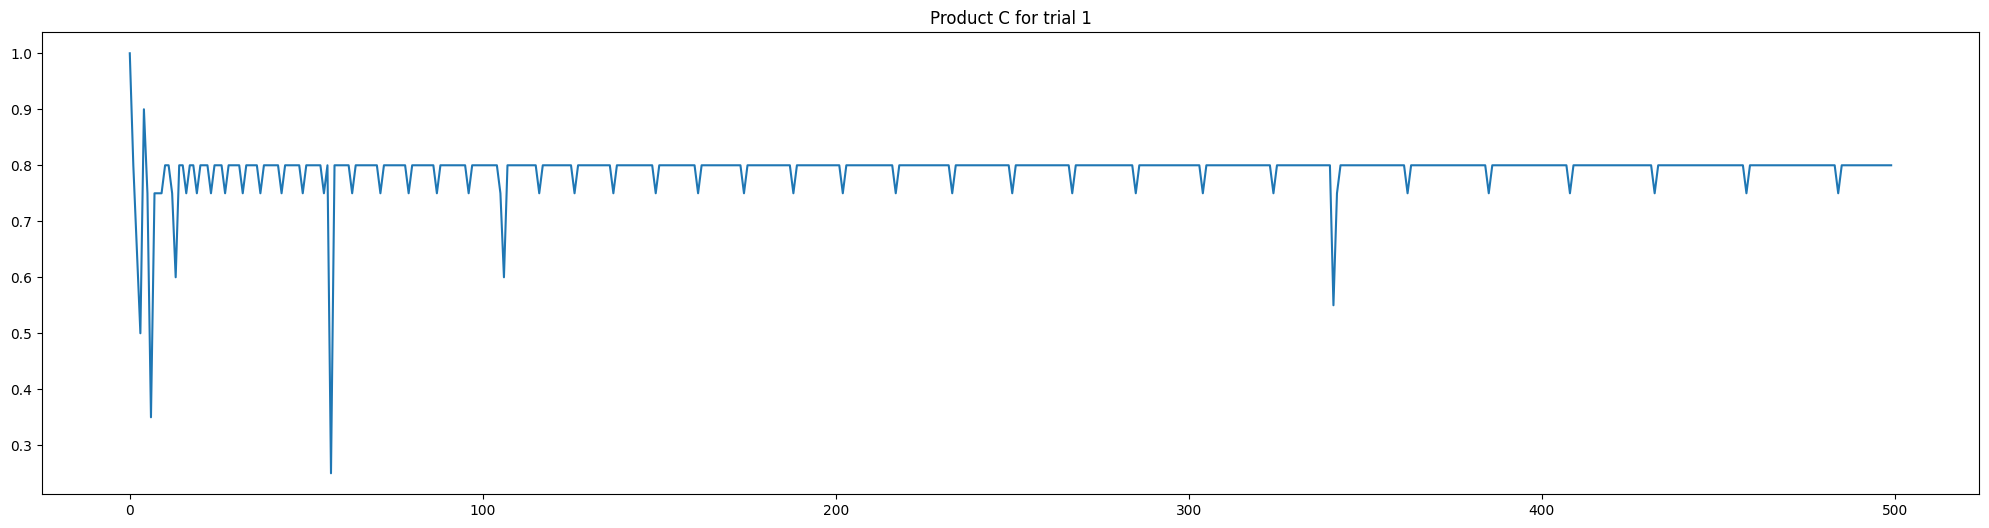

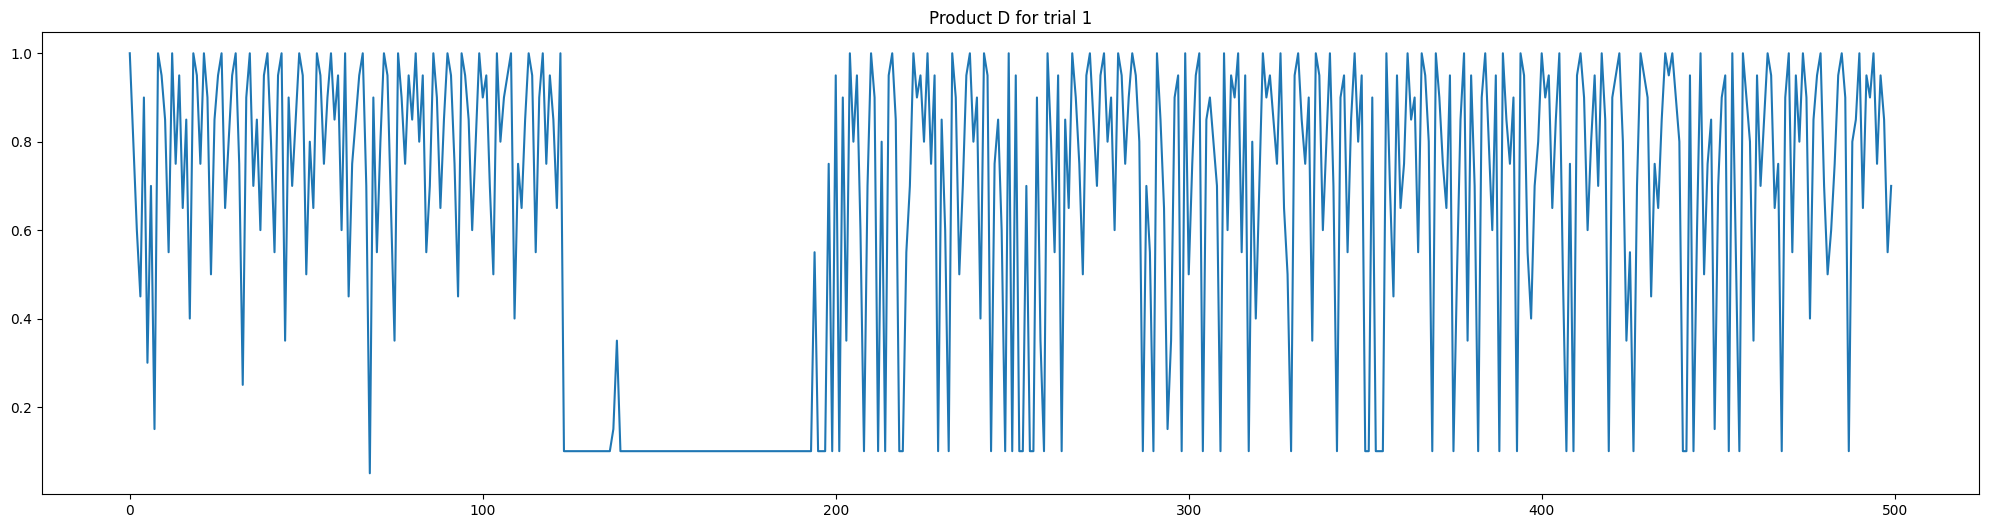

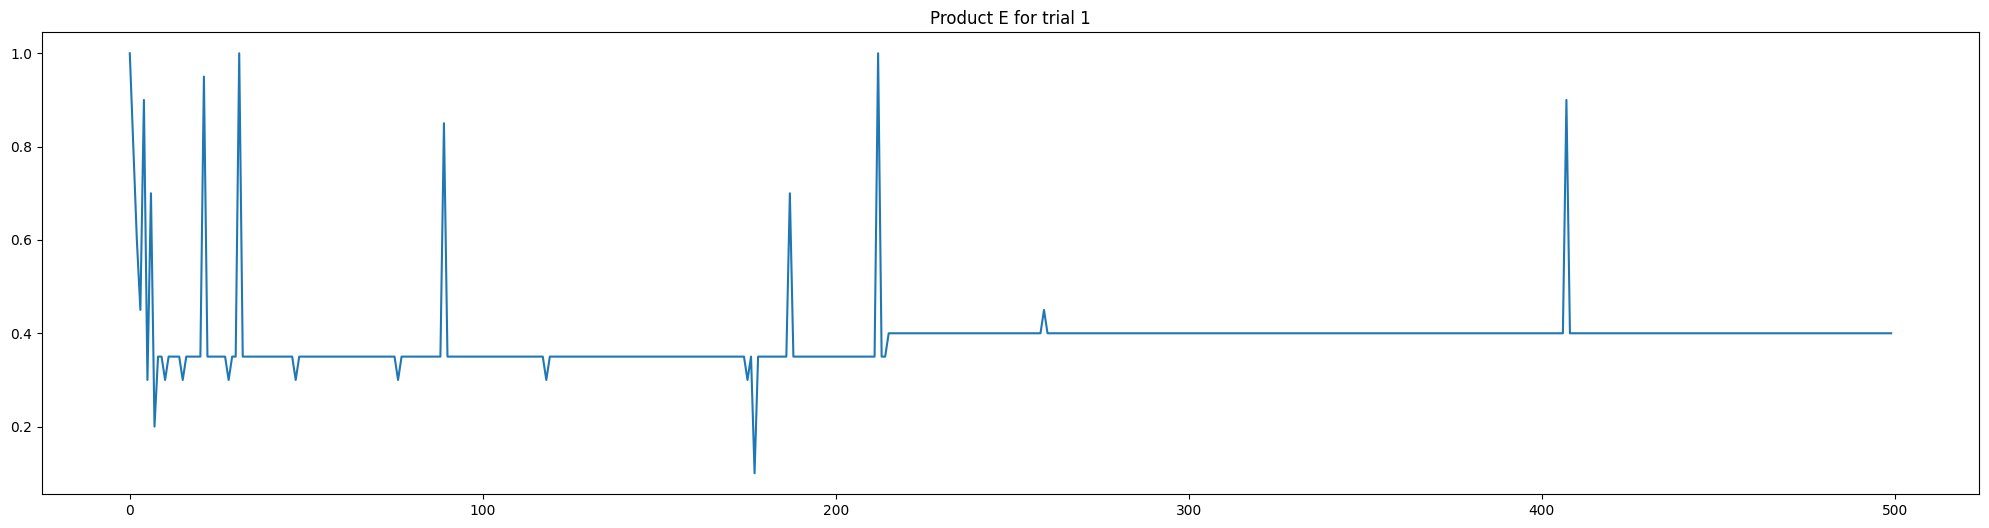

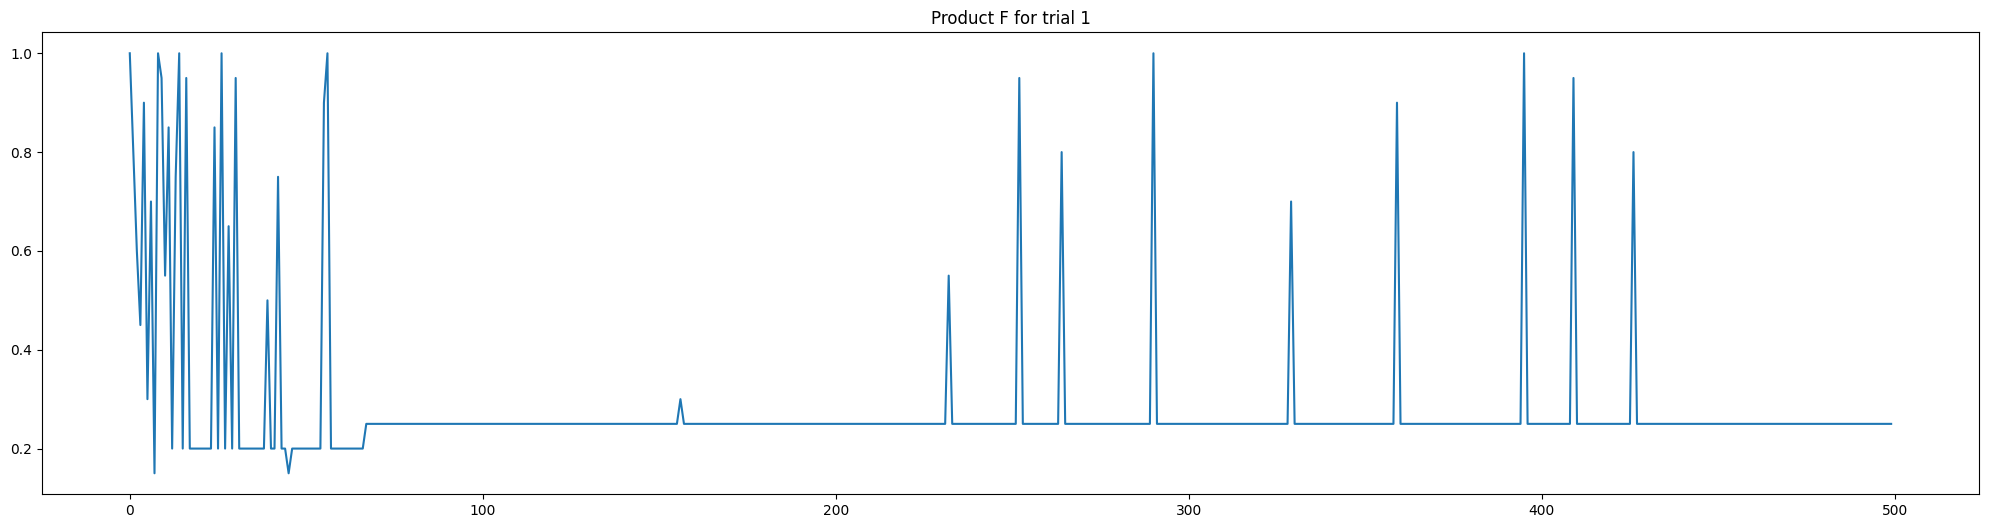

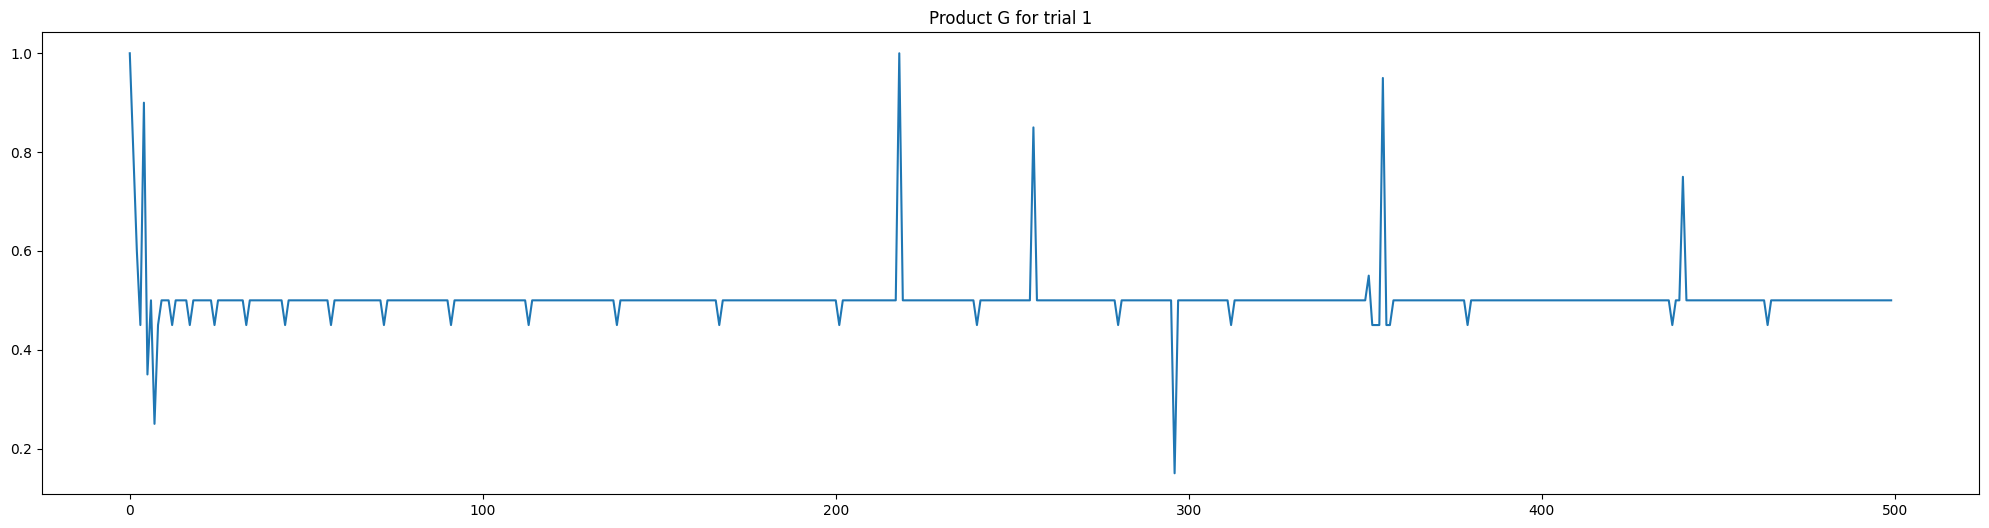

In [53]:
if run_one:
    actions_unpacked = [actions]
else:
    actions_unpacked = actions
    #actions_unpacked=[[trial] for trial in actions]


for t, trial in enumerate(actions_unpacked[:2]):
    x = range(len(trial))
    for i, product in enumerate(products):
        y = [step[i] for step in trial]
        plt.figure(figsize=(25,6))
        plt.plot(x, y)
        plt.title(f'Product {product} for trial {t}')
        plt.show()
